## load the dataset and create the final using dataset with attribute "Quadrant". 

In [6]:
import os
import pandas as pd
from pathlib import Path

ternary_folder_Q1 = Path("/hy-tmp/uncentred_ternary_224_stratified4fold_1000per_seed3888/Q1")
ternary_folder_Q2= Path("/hy-tmp/uncentred_ternary_224_stratified4fold_1000per_seed3888/Q2")
ternary_folder_Q3 = Path("/hy-tmp/uncentred_ternary_224_stratified4fold_1000per_seed3888/Q3")
ternary_folder_Q4 = Path("/hy-tmp/uncentred_ternary_224_stratified4fold_1000per_seed3888/Q4")
# multiclass_folder = Path("projectdata/images/uncentred_multiclass_224_stratified4fold_1000per_seed3888")


In [7]:
# Prepare a list for all records
records = []
cell_types = ["Tumor", "Non-Tumor", "Empty"]
    
# Traverse folders
def get_records(quadrant, path):
    records = []
    
    for folder_name in os.listdir(path):
        folder_path = Path(f"{path}/{folder_name}")
        if folder_path.is_dir():
            
            if folder_name not in cell_types:
                print(f"Warning: Folder {folder_name} not found in cell types. Skipping.")
                continue
    
            # Loop through images
            for file_name in os.listdir(folder_path):
                if file_name.endswith((".png", ".jpg", ".jpeg")):
                    full_path = f"{folder_path}/{file_name}"
                    filename = "grid_99_87_224.png"
                    parts = filename.replace(".png", "").split("_")
                    x = int(parts[1])
                    y = int(parts[2])
    
                    # Try to extract index from filename (assume number in filename)
                    # Example filename: "img_123.png" → index=123
                    import re
                    match = re.search(r'\d+', file_name)
                    img_index = int(match.group()) if match else None
    
                    records.append({
                        "Quadrant": quadrant,
                        "File Name": file_name,
                        "Path": str(full_path),
                        "Category Type": folder_name,
                        "Image Index": img_index,
                        "x":x,
                        "y":y
                    })
    return records

records_q1 = get_records("Q1", ternary_folder_Q1)
records_q2 = get_records("Q2", ternary_folder_Q2)
records_q3 = get_records("Q3", ternary_folder_Q3)
records_q4 = get_records("Q4", ternary_folder_Q4)

df_q1 = pd.DataFrame(records_q1)
df_q2 = pd.DataFrame(records_q2)
df_q3 = pd.DataFrame(records_q3)
df_q4 = pd.DataFrame(records_q4)

# # Create DataFrame
# df_image_raw = pd.DataFrame(records)
# df_image_raw.head()

# df_image = df_image_raw[df_image_raw['Category Type'] != "Unlabeled"].reset_index(drop=True)


In [8]:
df_final = pd.concat([df_q1, df_q2, df_q3, df_q4])
# df_final
df_final.to_csv("used_dataset_bindy.csv", index=False)
df_g = df_final.groupby("Category Type")["File Name"].count()
df_g

Category Type
Empty         400
Non-Tumor    2000
Tumor        2000
Name: File Name, dtype: int64

In [9]:
df_g2 = df_final.groupby("Quadrant")["Category Type"].count()
df_g2

Quadrant
Q1    1100
Q2    1100
Q3    1100
Q4    1100
Name: Category Type, dtype: int64

## Implementing the VGG16 model

In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set random seeds
np.random.seed(3888)
tf.random.set_seed(3888)

# # Load your balanced dataset
# df = df_final

# # Print basic info
# print(df['Category Type'].value_counts())
# print(df['Quadrant'].value_counts())

label_map = {'Tumor': 0, 'Non-Tumor': 1, 'Empty': 2}

df_q1['label'] = df_q1['Category Type'].map(label_map)
df_q1['label'] = df_q1['label'].astype(str)

df_q2['label'] = df_q2['Category Type'].map(label_map)
df_q2['label'] = df_q2['label'].astype(str)

df_q3['label'] = df_q3['Category Type'].map(label_map)
df_q3['label'] = df_q3['label'].astype(str)

df_q4['label'] = df_q4['Category Type'].map(label_map)
df_q4['label'] = df_q4['label'].astype(str)

def build_vgg16_model(input_shape=(224, 224, 3), path=None):
    base_model = VGG16(weights='imagenet' or path, include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)  # 3 classes

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


Starting Fold: Test on Q1
Found 1100 validated image filenames belonging to 3 classes.
Found 3300 validated image filenames belonging to 3 classes.


A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6d6bbae143d832006294945121d1f1fc so we will re-download the data.
58889256/58889256 [==============================] - 12s 0us/step
Epoch 1/20


2025-05-07 09:21:31.574913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-05-07 09:21:33.455717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2025-05-07 09:21:34.222802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-05-07 09:21:34.744593: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x9d57c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-07 09:21:34.744649: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-05-07 09:21:34.771047: I 

35/35 [==============================] - ETA: 0s - loss: 0.9920 - accuracy: 0.4764

2025-05-07 09:21:50.588468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 29s 728ms/step - loss: 0.9920 - accuracy: 0.4764 - val_loss: 0.8364 - val_accuracy: 0.6273
Epoch 2/20
35/35 [==============================] - 24s 689ms/step - loss: 0.8210 - accuracy: 0.5845 - val_loss: 0.7438 - val_accuracy: 0.6742
Epoch 3/20
35/35 [==============================] - 24s 678ms/step - loss: 0.7530 - accuracy: 0.6282 - val_loss: 0.6829 - val_accuracy: 0.6745
Epoch 4/20
35/35 [==============================] - 24s 677ms/step - loss: 0.6840 - accuracy: 0.6755 - val_loss: 0.6274 - val_accuracy: 0.6855
Epoch 5/20
35/35 [==============================] - 23s 666ms/step - loss: 0.6229 - accuracy: 0.7136 - val_loss: 0.5852 - val_accuracy: 0.7000
Epoch 6/20
35/35 [==============================] - 24s 700ms/step - loss: 0.5704 - accuracy: 0.7745 - val_loss: 0.5590 - val_accuracy: 0.7600
Epoch 7/20
35/35 [==============================] - 24s 699ms/step - loss: 0.5248 - accuracy: 0.8009 - val_loss: 0.5387 - val_accuracy: 0.7676
Epoch 8/20

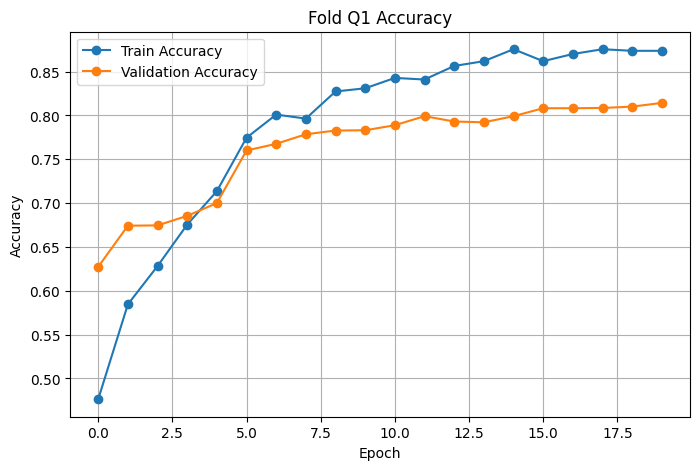

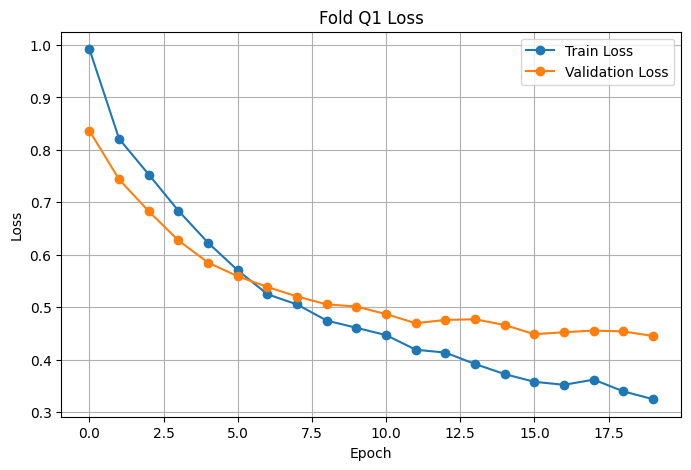

Saved model: vgg16_fold_Q1.h5


2025-05-07 09:29:32.912136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - 10s 95ms/step


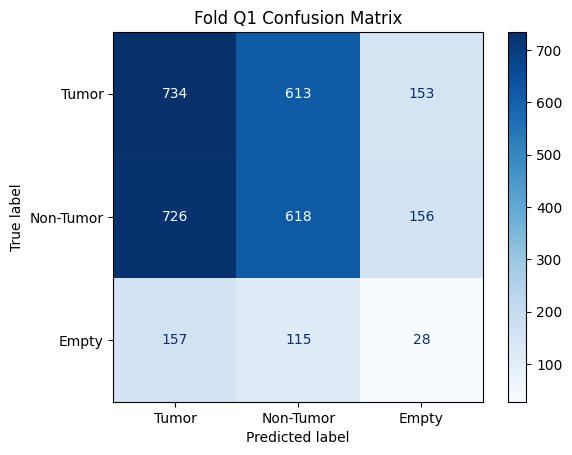

Fold Q1 Accuracy: 0.4182, F1 Score: 0.3311
Classification Report for Fold Q1:
              precision    recall  f1-score   support

       Tumor     0.4539    0.4893    0.4710      1500
   Non-Tumor     0.4591    0.4120    0.4343      1500
       Empty     0.0831    0.0933    0.0879       300

    accuracy                         0.4182      3300
   macro avg     0.3321    0.3316    0.3311      3300
weighted avg     0.4226    0.4182    0.4195      3300

Starting Fold: Test on Q2
Found 1100 validated image filenames belonging to 3 classes.
Found 3300 validated image filenames belonging to 3 classes.
Epoch 1/20


2025-05-07 09:29:44.515879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - ETA: 0s - loss: 0.9913 - accuracy: 0.4882

2025-05-07 09:30:00.172567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 25s 686ms/step - loss: 0.9913 - accuracy: 0.4882 - val_loss: 0.8208 - val_accuracy: 0.6339
Epoch 2/20
35/35 [==============================] - 24s 681ms/step - loss: 0.8234 - accuracy: 0.5809 - val_loss: 0.7180 - val_accuracy: 0.7121
Epoch 3/20
35/35 [==============================] - 23s 671ms/step - loss: 0.7316 - accuracy: 0.6591 - val_loss: 0.6574 - val_accuracy: 0.6848
Epoch 4/20
35/35 [==============================] - 24s 686ms/step - loss: 0.6722 - accuracy: 0.6845 - val_loss: 0.6015 - val_accuracy: 0.7152
Epoch 5/20
35/35 [==============================] - 24s 696ms/step - loss: 0.6121 - accuracy: 0.7055 - val_loss: 0.5623 - val_accuracy: 0.7285
Epoch 6/20
35/35 [==============================] - 24s 677ms/step - loss: 0.5783 - accuracy: 0.7473 - val_loss: 0.5450 - val_accuracy: 0.7700
Epoch 7/20
35/35 [==============================] - 24s 696ms/step - loss: 0.5533 - accuracy: 0.7609 - val_loss: 0.5206 - val_accuracy: 0.7876
Epoch 8/20

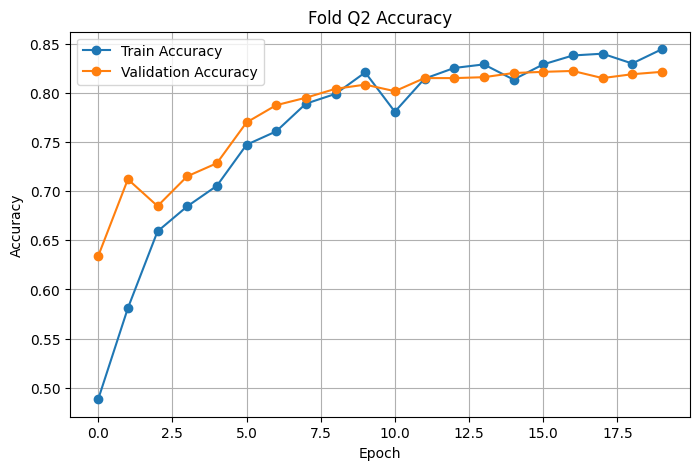

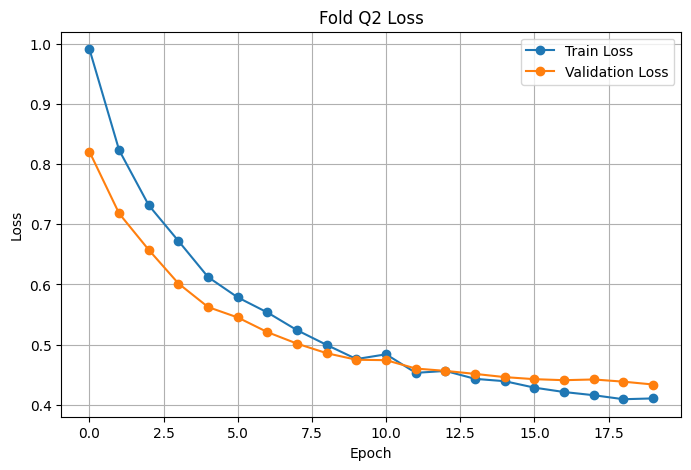

Saved model: vgg16_fold_Q2.h5


2025-05-07 09:37:42.373780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - 10s 90ms/step


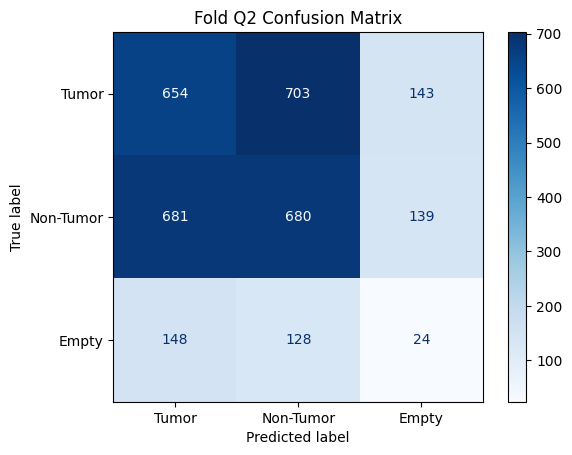

Fold Q2 Accuracy: 0.4115, F1 Score: 0.3231
Classification Report for Fold Q2:
              precision    recall  f1-score   support

       Tumor     0.4410    0.4360    0.4385      1500
   Non-Tumor     0.4500    0.4533    0.4517      1500
       Empty     0.0784    0.0800    0.0792       300

    accuracy                         0.4115      3300
   macro avg     0.3232    0.3231    0.3231      3300
weighted avg     0.4121    0.4115    0.4118      3300

Starting Fold: Test on Q3
Found 1100 validated image filenames belonging to 3 classes.
Found 3300 validated image filenames belonging to 3 classes.
Epoch 1/20


2025-05-07 09:37:53.364606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - ETA: 0s - loss: 0.9882 - accuracy: 0.4673

2025-05-07 09:38:09.734888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 26s 689ms/step - loss: 0.9882 - accuracy: 0.4673 - val_loss: 0.8193 - val_accuracy: 0.6930
Epoch 2/20
35/35 [==============================] - 23s 674ms/step - loss: 0.8320 - accuracy: 0.5727 - val_loss: 0.7339 - val_accuracy: 0.6909
Epoch 3/20
35/35 [==============================] - 23s 673ms/step - loss: 0.7300 - accuracy: 0.6473 - val_loss: 0.6740 - val_accuracy: 0.6785
Epoch 4/20
35/35 [==============================] - 24s 674ms/step - loss: 0.6634 - accuracy: 0.7045 - val_loss: 0.6255 - val_accuracy: 0.7021
Epoch 5/20
35/35 [==============================] - 24s 687ms/step - loss: 0.6083 - accuracy: 0.7355 - val_loss: 0.5909 - val_accuracy: 0.7318
Epoch 6/20
35/35 [==============================] - 23s 672ms/step - loss: 0.5634 - accuracy: 0.7591 - val_loss: 0.5690 - val_accuracy: 0.7806
Epoch 7/20
35/35 [==============================] - 24s 686ms/step - loss: 0.5323 - accuracy: 0.7736 - val_loss: 0.5487 - val_accuracy: 0.7897
Epoch 8/20

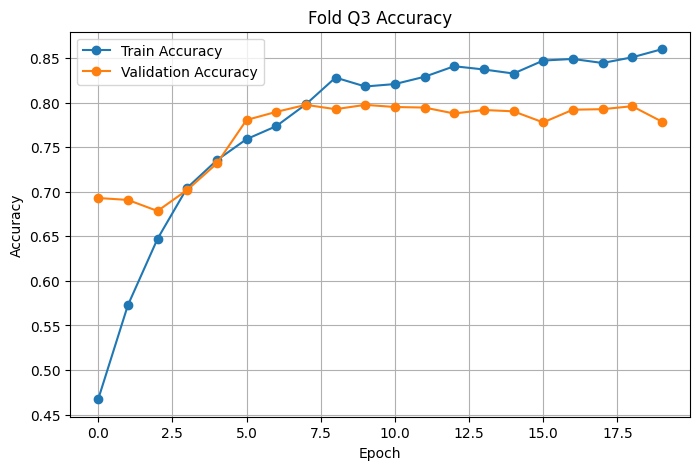

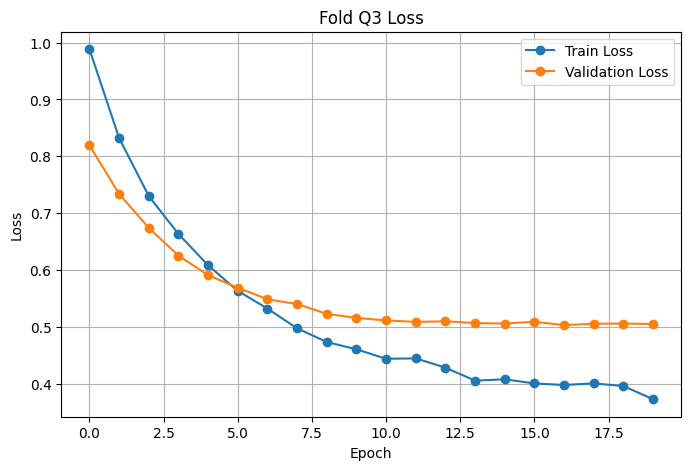

Saved model: vgg16_fold_Q3.h5


2025-05-07 09:45:51.881449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - 10s 89ms/step


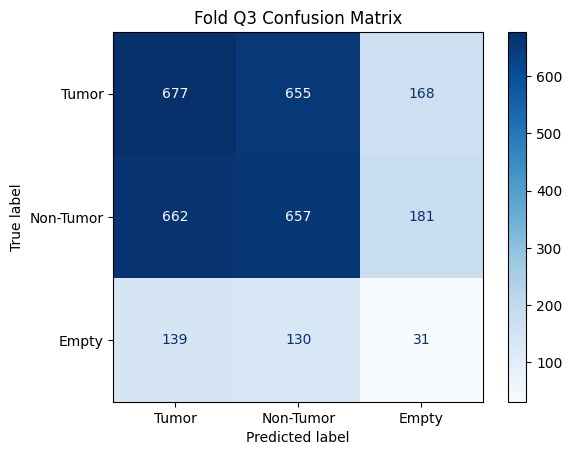

Fold Q3 Accuracy: 0.4136, F1 Score: 0.3308
Classification Report for Fold Q3:
              precision    recall  f1-score   support

       Tumor     0.4581    0.4513    0.4547      1500
   Non-Tumor     0.4556    0.4380    0.4466      1500
       Empty     0.0816    0.1033    0.0912       300

    accuracy                         0.4136      3300
   macro avg     0.3317    0.3309    0.3308      3300
weighted avg     0.4227    0.4136    0.4180      3300

Starting Fold: Test on Q4
Found 1100 validated image filenames belonging to 3 classes.
Found 3300 validated image filenames belonging to 3 classes.
Epoch 1/20


2025-05-07 09:46:02.882398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - ETA: 0s - loss: 0.9736 - accuracy: 0.4864

2025-05-07 09:46:18.449251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - 25s 682ms/step - loss: 0.9736 - accuracy: 0.4864 - val_loss: 0.7934 - val_accuracy: 0.7003
Epoch 2/20
35/35 [==============================] - 24s 682ms/step - loss: 0.8227 - accuracy: 0.5800 - val_loss: 0.7164 - val_accuracy: 0.6870
Epoch 3/20
35/35 [==============================] - 24s 678ms/step - loss: 0.7299 - accuracy: 0.6491 - val_loss: 0.6519 - val_accuracy: 0.7039
Epoch 4/20
35/35 [==============================] - 23s 675ms/step - loss: 0.6913 - accuracy: 0.6591 - val_loss: 0.6346 - val_accuracy: 0.6639
Epoch 5/20
35/35 [==============================] - 24s 676ms/step - loss: 0.6474 - accuracy: 0.6991 - val_loss: 0.6002 - val_accuracy: 0.6752
Epoch 6/20
35/35 [==============================] - 24s 681ms/step - loss: 0.6108 - accuracy: 0.7273 - val_loss: 0.5607 - val_accuracy: 0.7024
Epoch 7/20
35/35 [==============================] - 24s 689ms/step - loss: 0.5801 - accuracy: 0.7391 - val_loss: 0.5472 - val_accuracy: 0.7512
Epoch 8/20

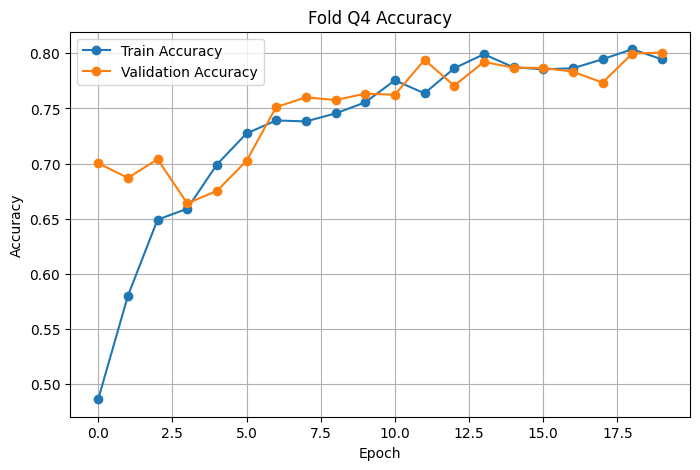

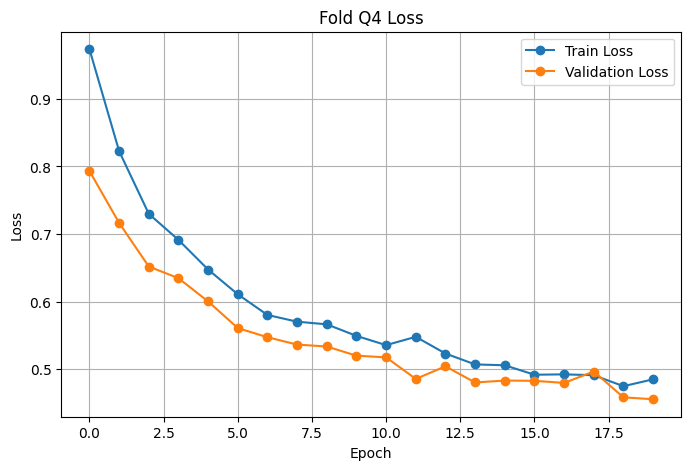

Saved model: vgg16_fold_Q4.h5


2025-05-07 09:53:59.938670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - 9s 86ms/step


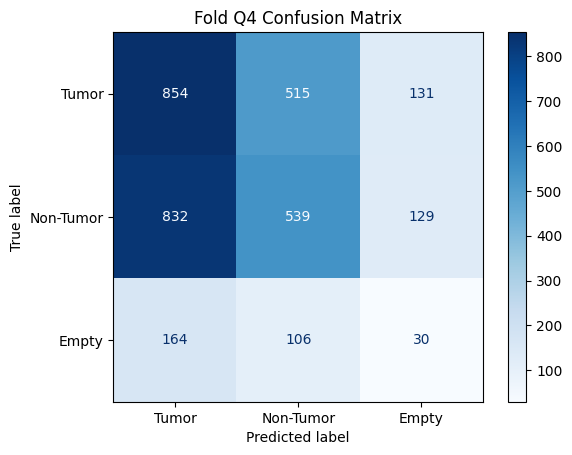

Fold Q4 Accuracy: 0.4312, F1 Score: 0.3389
Classification Report for Fold Q4:
              precision    recall  f1-score   support

       Tumor     0.4616    0.5693    0.5099      1500
   Non-Tumor     0.4647    0.3593    0.4053      1500
       Empty     0.1034    0.1000    0.1017       300

    accuracy                         0.4312      3300
   macro avg     0.3432    0.3429    0.3389      3300
weighted avg     0.4304    0.4312    0.4252      3300

Average 4-Fold Test Accuracy: 0.4186
Average 4-Fold Test Accuracy: 0.3310


In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Set random seeds
np.random.seed(3888)
tf.random.set_seed(3888)

# Prepare ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

quadrant_dfs = {
    "Q1": df_q1,
    "Q2": df_q2,
    "Q3": df_q3,
    "Q4": df_q4
}

# Store results
fold_accuracies = []
fold_f1_scores = []
fold_reports = []
models = {}

for quadrant in ["Q1","Q2","Q3","Q4"]:
    print(f"Starting Fold: Test on {quadrant}")

    # Split
    train_df = quadrant_dfs[quadrant]
    val_quads = [q for q in quadrant_dfs if q != quadrant]
    val_df = pd.concat([quadrant_dfs[q] for q in val_quads], ignore_index=True)

    # # Further split train/val internally
    # train_df, val_df = train_test_split(
    #     train_val_df, 
    #     test_size=0.2, 
    #     stratify=train_val_df['label'], 
    #     random_state=3888
    # )

    # Data Generators
    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col='Path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    val_gen = val_test_datagen.flow_from_dataframe(
        val_df,
        x_col='Path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    # test_gen = val_test_datagen.flow_from_dataframe(
    #     test_df,
    #     x_col='Path',
    #     y_col='label',
    #     target_size=(224, 224),
    #     batch_size=32,
    #     class_mode='binary',
    #     shuffle=False
    # )

    # Build Model
    local_path = "/hy-tmp/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    model = build_vgg16_model(path = local_path)

    # Train
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluate

    # --- Plot training curves ---
    
    # Accuracy
    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title(f'Fold {quadrant} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Loss
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title(f'Fold {quadrant} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
    
    # --- Save model ---
    model.save(f"vgg16_fold_{quadrant}.h5")
    
    models[quadrant] = model
    
    print(f"Saved model: vgg16_fold_{quadrant}.h5")
    
    # --- Confusion Matrix on Val Set ---
    val_gen.reset()
    y_true = val_gen.classes
    y_pred_probs = model.predict(val_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Tumor", "Non-Tumor", "Empty"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Fold {quadrant} Confusion Matrix')
    plt.show()

    acc = np.mean(y_true == y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Fold {quadrant} Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

    fold_accuracies.append(acc)
    fold_f1_scores.append(f1)

    # --- Classification Report ---
    report = classification_report(
    y_true, 
    y_pred, 
    target_names=["Tumor", "Non-Tumor", "Empty"],
    digits=4
    )
    fold_reports.append(report)
    print(f"Classification Report for Fold {quadrant}:\n{report}")

# Final report
mean_acc = np.mean(fold_accuracies)
mean_f1 = np.mean(fold_f1_scores)
print(f"Average 4-Fold Test Accuracy: {mean_acc:.4f}")
print(f"Average 4-Fold Test Accuracy: {mean_f1:.4f}")


In [16]:
print(f"Accuracy of Model using Q1: {fold_accuracies[0]}")
print(f"Accuracy of Model using Q2: {fold_accuracies[1]}")
print(f"Accuracy of Model using Q3: {fold_accuracies[2]}")
print(f"Accuracy of Model using Q4: {fold_accuracies[3]}")

Accuracy of Model using Q1: 0.41818181818181815
Accuracy of Model using Q2: 0.4115151515151515
Accuracy of Model using Q3: 0.41363636363636364
Accuracy of Model using Q4: 0.4312121212121212


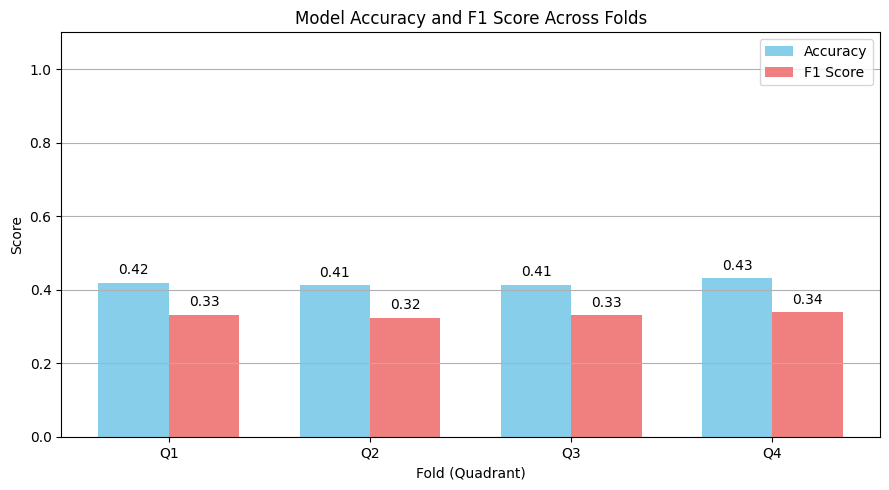

In [17]:
folds = ["Q1", "Q2", "Q3", "Q4"]

x = np.arange(len(folds))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(9, 5))

rects1 = ax.bar(x - width/2, fold_accuracies, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, fold_f1_scores, width, label='F1 Score', color='lightcoral')

# Labels and formatting
ax.set_ylabel('Score')
ax.set_xlabel('Fold (Quadrant)')
ax.set_title('Model Accuracy and F1 Score Across Folds')
ax.set_xticks(x)
ax.set_xticklabels(folds)
ax.set_ylim(0, 1.1)
ax.legend()

# Annotate each bar
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [21]:
!pip install opencv-python

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 3.3 MB/s eta 0:00:0000:0100:01


In [22]:
import cv2
import pandas as pd
from PIL import Image
import matplotlib.patches as patches
from tensorflow.keras.applications.vgg16 import preprocess_input

Image.MAX_IMAGE_PIXELS = None

# CONFIG
PATCH_SIZE = 224  # should match IMAGE_SIZE
STRIDE = 224  # adjust stride for overlapping or non-overlapping
CLASS_COLORS = {'Tumor': 0, 'Non-Tumor': 1, 'Empty': 2}
COLOR_MAP = {0: 'blue', 1: 'green', 2: 'red'}

# Load the big image
big_img = Image.open('BigImage.tif').convert('RGB')
big_arr = np.array(big_img)
h, w, _ = big_arr.shape

# model_input = preprocess_input  

# Load best-performing model
folds = ["Q1", "Q2", "Q3", "Q4"]
best_fold = folds[np.argmax(fold_f1_scores)]
best_model_path = f"vgg16_fold_{best_fold}.h5"
model = tf.keras.models.load_model(best_model_path)
print(f"Using best model from fold {best_fold}")

# ---------------- HEATMAP INFERENCE ----------------
heatmap = np.zeros((h // STRIDE, w // STRIDE), dtype=int)

for i_idx, i in enumerate(range(0, h - PATCH_SIZE + 1, STRIDE)):
    for j_idx, j in enumerate(range(0, w - PATCH_SIZE + 1, STRIDE)):
        patch = big_arr[i:i+PATCH_SIZE, j:j+PATCH_SIZE]
        patch_resized = cv2.resize(patch, IMAGE_SIZE).astype(np.float32)
        patch_input = preprocess_input(np.expand_dims(patch_resized, axis=0))  # for VGG16
        pred = model.predict(patch_input, verbose=0)
        label = np.argmax(pred)
        heatmap[i_idx, j_idx] = label

# ---------------- PLOT HEATMAP ----------------
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap, cmap='coolwarm', cbar_kws={'ticks': [0, 1, 2]},
            xticklabels=False, yticklabels=False)
plt.title(f'Prediction Heatmap using Fold {best_fold} Model')
cbar = plt.gca().collections[0].colorbar
cbar.set_ticklabels(CLASS_LABELS)
plt.tight_layout()
plt.show()


ImportError: libGL.so.1: cannot open shared object file: No such file or directory

In [23]:
df = df_final
tumor_coords = []

for col in df.columns:
    if 'x' in col:
        y_col = col.replace('x', 'y')
        xs = df[col].dropna()
        ys = df[y_col].dropna()
        tumor_coords.extend(zip(xs.astype(int), ys.astype(int)))

# Build ground truth grid
gt_map = np.zeros_like(heatmap)

for x, y in tumor_coords:
    if x < w and y < h:
        i = y // STRIDE
        j = x // STRIDE
        if i < gt_map.shape[0] and j < gt_map.shape[1]:
            gt_map[i, j] = 2  # mark as tumor

# Plot heatmap with overlay
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap, cmap='coolwarm', xticklabels=False, yticklabels=False, cbar=False)
plt.title('Prediction Heatmap with Ground Truth Overlay')

# Overlay ground truth (tumor) cells
for i in range(gt_map.shape[0]):
    for j in range(gt_map.shape[1]):
        if gt_map[i, j] == 2:
            plt.gca().add_patch(patches.Rectangle((j, i), 1, 1, edgecolor='yellow', fill=False, linewidth=1))

plt.show()

KeyError: 'Image Indey'